# Example Training for Normalizing Flows

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import os
import random

from data.visu_density import plot_heatmap_2d
from data.plot_samples import plot_samples_2d
from utils.train_utils import sanity_check, train_density_estimation, nll
from normalizingflows.flow_catalog import RealNVP
from data.data_manager import Dataset

tfd = tfp.distributions
tfb = tfp.bijectors

tf.random.set_seed(1234)

os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

tensorflow:  2.8.0
tensorflow-probability:  0.15.0


/home/marcel/Repos/normalizing-flows/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load Data
First, load the data you want to train the normalizing flow on. Available datasets are various toy data distributions, the datasets POWER, GAS, and MINIBOONE from the UCI machine learning repository, MNIST, and CelebA. This example is on the 2D toy dataset "tum". Note that for 2D toy data the train data is returned already in batches, while the validation and test data is returned unbatched.

In [2]:
dataset_size = 2000  # ony necessary for toy data distributions
batch_size = 800
dataset_name = 'moons'

In [3]:
dataset = Dataset(dataset_name, batch_size=batch_size)
batched_train_data, val_data, test_data = dataset.get_data()

2022-03-25 23:58:37.981542: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-25 23:58:37.987807: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-25 23:58:37.988094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-25 23:58:37.988739: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

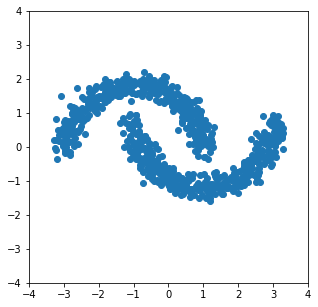

In [4]:
sample_batch = next(iter(batched_train_data))
plot_samples_2d(sample_batch)

## 2. Build the Normalizing Flow


In [5]:
layers = 6
dimensions = 2
hidden_units = [512, 512]

In [6]:
def create_flow(training: bool):
    bijectors = []
    base_dist = tfd.Normal(loc=0.0, scale=1.0)
    for i in range(layers):
        bijectors.append(tfb.BatchNormalization(training=training))
        bijectors.append(RealNVP(input_shape=dimensions, n_hidden=hidden_units))
        bijectors.append(tfp.bijectors.Permute([1, 0]))

    bijector = tfb.Chain(bijectors=list(reversed(bijectors)), name='chain_of_real_nvp')
    return tfd.TransformedDistribution(
        distribution=tfd.Sample(base_dist, sample_shape=[dimensions]),
        bijector=bijector
    )

In [7]:
flow = create_flow(training=True)
n_trainable_variables = len(flow.trainable_variables)

2022-03-25 23:58:39.197156: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


## 3. Train the Normalizing Flow
In this example we train the flow with a polynomial learning rate decay. Afer the training, the checkpoint with the best performance on the validation set is reloaded and tested on the test dataset. Early stopping is used, if the validation loss does not decrease for "delta_stop" epochs.

In [8]:
base_lr = 1e-3
end_lr = 1e-4
max_epochs = int(5e3)  # maximum number of epochs of the training
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(base_lr, max_epochs, end_lr, power=0.5)

In [9]:
# initialize checkpoints
checkpoint_directory = "{}/tmp_{}".format(dataset_name, str(hex(random.getrandbits(32))))
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)  # optimizer
checkpoint = tf.train.Checkpoint(optimizer=opt, model=flow)

In [10]:
global_step = []
train_losses = []
val_losses = []
min_val_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)  # high value to ensure that first loss < min_loss
min_train_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)
min_val_epoch = 0
min_train_epoch = 0
delta_stop = 1000  # threshold for early stopping

t_start = time.time()  # start time

# start training
for i in range(max_epochs):
    for batch in batched_train_data:
        train_loss = train_density_estimation(flow, opt, batch)

    if i % int(100) == 0:
        val_loss = nll(flow, val_data)
        global_step.append(i)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"{i}, train_loss: {train_loss}, val_loss: {val_loss}")

        if train_loss < min_train_loss:
            min_train_loss = train_loss
            min_train_epoch = i

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            min_val_epoch = i
            checkpoint.write(file_prefix=checkpoint_prefix)  # overwrite best val model

        elif i - min_val_epoch > delta_stop:  # no decrease in min_val_loss for "delta_stop epochs"
            break

train_time = time.time() - t_start

/home/marcel/Repos/normalizing-flows/.venv/lib/python3.9/site-packages/tensorflow_probability/python/bijectors/batch_normalization.py:210: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return self.batchnorm.apply(y, training=self._training)


0, train_loss: 3.6494576930999756, val_loss: 3.3055553436279297
100, train_loss: 2.472184896469116, val_loss: 2.7424399852752686
200, train_loss: 2.4849681854248047, val_loss: 2.635953664779663
300, train_loss: 2.432880401611328, val_loss: 2.8089163303375244
400, train_loss: 2.3988683223724365, val_loss: 2.767803430557251
500, train_loss: 2.4067025184631348, val_loss: 2.5720837116241455
600, train_loss: 2.375256299972534, val_loss: 2.6017873287200928
700, train_loss: 2.360283613204956, val_loss: 2.5976192951202393
800, train_loss: 2.4523606300354004, val_loss: 2.547548294067383
900, train_loss: 2.3440990447998047, val_loss: 2.5454442501068115
1000, train_loss: 2.368365526199341, val_loss: 2.560441255569458
1100, train_loss: 2.3458986282348633, val_loss: 2.570298433303833
1200, train_loss: 2.347395896911621, val_loss: 2.6078217029571533
1300, train_loss: 2.325392961502075, val_loss: 2.6740047931671143
1400, train_loss: 2.3341495990753174, val_loss: 3.043865919113159
1500, train_loss: 2.

tf.Tensor(3.0885446, shape=(), dtype=float32)


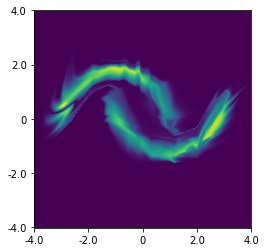

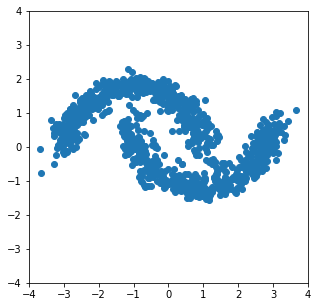

In [11]:
# Reload best model
flow = create_flow(training=False)
checkpoint = tf.train.Checkpoint(model=flow)
checkpoint.restore(checkpoint_prefix)

# perform on test dataset
t_start = time.time()
test_loss = -tf.reduce_mean(flow.log_prob(test_data))
test_time = time.time() - t_start
print(test_loss)

# plot density estimation of the best model
plot_heatmap_2d(flow, -4.0, 4.0, -4.0, 4.0, mesh_count=200, name=None)  # to save the image, specify a directory as name

# plot samples of the best model
plot_samples_2d(flow.sample(1000), name=None)  # to save the image, specify a directory as name

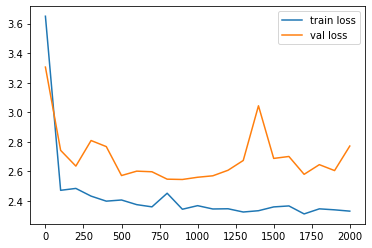

In [12]:
# plot train and validation loss curve
plt.plot(global_step, train_losses, label="train loss")
plt.plot(global_step, val_losses, label="val loss")
plt.legend()

## 4. Sanity Check
On 2D toy data, a sanity check can be performed. The sanity check approximates the integral of the probability density function on the specified area. The approxmiated integral should be close to 1.

In [13]:
integral = sanity_check(flow, xmin=-4.0, xmax=4.0, ymin=-4.0, ymax=4.0, mesh_count=250)
print(integral)

tf.Tensor(0.9918865, shape=(), dtype=float32)


## 5. Delete unnecessary checkpoints

In [14]:
filelist = [f for f in os.listdir(checkpoint_directory)]
for f in filelist:
    os.remove(os.path.join(checkpoint_directory, f))
os.removedirs(checkpoint_directory)